env.countstate =  4032
env.currentstate =  []
Episode number 0 completed with reward -86 and goal reward 0 in 77 steps 
Average reward after 0 episodes = : -86.0 
time elapsed in seconds =  6527.4066547


c:\Users\murtuza.morbiwala.sa\miniforge3\envs\soccerbot_env\lib\site-packages\ipykernel_launcher.py:109: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Episode number 1 completed with reward -100 and goal reward 0 in 100 steps 
Episode number 2 completed with reward -100 and goal reward 0 in 100 steps 
Episode number 3 completed with reward -100 and goal reward 0 in 100 steps 
Episode number 4 completed with reward -100 and goal reward 0 in 100 steps 
Episode number 5 completed with reward -88 and goal reward 0 in 79 steps 
Episode number 6 completed with reward -100 and goal reward 0 in 100 steps 
Episode number 7 completed with reward -100 and goal reward 0 in 100 steps 
Episode number 8 completed with reward -100 and goal reward 0 in 100 steps 
Episode number 9 completed with reward -100 and goal reward 0 in 100 steps 
Episode number 10 completed with reward -100 and goal reward 0 in 100 steps 
Episode number 11 completed with reward -100 and goal reward 0 in 100 steps 
Episode number 12 completed with reward -100 and goal reward 0 in 100 steps 
Episode number 13 completed with reward -100 and goal reward 0 in 100 steps 
Episode nu

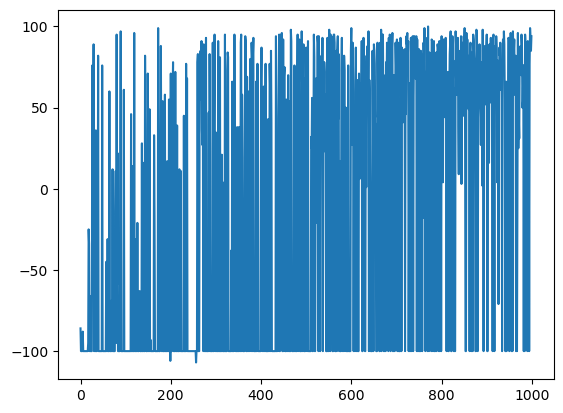

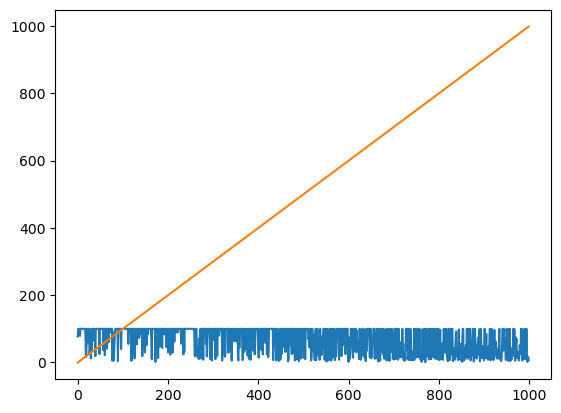

[[-86, 0], [-100, 1], [-100, 2], [-100, 3], [-100, 4], [-88, 5], [-100, 6], [-100, 7], [-100, 8], [-100, 9], [-100, 10], [-100, 11], [-100, 12], [-100, 13], [-100, 14], [-100, 15], [-100, 16], [-95, 17], [-25, 18], [-34, 19], [-100, 20], [-66, 21], [-100, 22], [-100, 23], [-100, 24], [-100, 25], [76, 26], [-43, 27], [26, 28], [89, 29], [-100, 30], [-42, 31], [-100, 32], [-100, 33], [36, 34], [-100, 35], [-100, 36], [-97, 37], [-80, 38], [82, 39], [-100, 40], [-100, 41], [-100, 42], [-100, 43], [-100, 44], [-100, 45], [-100, 46], [-100, 47], [76, 48], [-100, 49], [-100, 50], [-100, 51], [-100, 52], [-100, 53], [-100, 54], [-100, 55], [-100, 56], [-45, 57], [-100, 58], [-100, 59], [-31, 60], [-100, 61], [-100, 62], [-100, 63], [60, 64], [-100, 65], [-100, 66], [-100, 67], [-69, 68], [-100, 69], [-100, 70], [12, 71], [-100, 72], [-100, 73], [-100, 74], [-100, 75], [-100, 76], [-14, 77], [11, 78], [-95, 79], [95, 80], [-59, 81], [22, 82], [-100, 83], [-100, 84], [-100, 85], [-100, 86], [-1

In [32]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import pylab as p
from  soccerworld_gym_env import SoccerWorld as sc
import time

import logging
from importlib import reload
reload(logging)
LOG_FILENAME = r'soccer.log'


logging.basicConfig(filename=LOG_FILENAME ,level=logging.DEBUG)

logging.debug('This message should go to the log file')
logging.info('So should this')
logging.warning('And this, too')


env = sc.Soccerworld()

#env = gym.make('FrozenLake-v0')

print ("env.countstate = ", env.countstate)
print ("env.currentstate = ", env.currentstate)


observations = env.countstate
actions = 4

tf.reset_default_graph()



#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,observations],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([observations,actions],0,0.01),name = 'W')
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,actions],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver([W])

# Set learning parameters
y = .99
e = 0.3
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []
rList1 = []
rGoalList = []
with tf.Session() as sess:
    
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        rGoal = 0
        d = False
        j = 0
        #The Q-Network
        while j < 200:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(observations)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.actionspacesample()
            #print("Action Selected = ",a[0])
            #Get new state and reward from environment
            s1,r,d = env.step(a[0])
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(observations)[s1:s1+1]})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(observations)[s:s+1],nextQ:targetQ})
            rAll += r
            if r>0:
                rGoal += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/75) + 10)
                break

        jList.append([j,i])
        rList.append(rAll)
        rList1.append([rAll,i])
        rGoalList.append([rGoal,i])

       
        print("Episode number {0} completed with reward {1} and goal reward {2} in {3} steps ".format(i, rAll, rGoal,j))

        if i%100 == 0:
            print("Average reward after {0} episodes = : {1} ".format(i, str(sum(rList) / (i + 1))))
            print("time elapsed in seconds = ", time.clock())
    
    save_path = saver.save(sess,'savemodel/model.ckpt')
#print("The weights for the neural network after episode {0} are: ".format(num_episodes, W1))
#print("Average reward after {0} episodes = : " + str(sum(rList)/num_episodes))




p.plot(rList)
p.show()
p.plot(jList)
p.show()


print(rList1)
print(jList)
print(rGoalList)


In [5]:
print("Hello, World!")

from soccerworld_gym_env import SoccerWorld as sc


Hello, World!


In [34]:
import tensorflow as tf
from soccerworld_gym_env import SoccerWorld as sc
import time
from IPython.display import clear_output
env = sc.Soccerworld()
import numpy as np
observations = env.countstate
actions = 4
e = 0.2

inputs1 = tf.placeholder(shape=[1,observations],dtype=tf.float32)

xa=3
ya=3
xb=4
yb=4

def soccerpredict(xa,ya,xb,yb):
    s = env.getstate(xa,ya,xb,yb)
    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph('savemodel/model.ckpt.meta')
        new_saver.restore(sess, tf.train.latest_checkpoint('savemodel/'))
        graph = tf.get_default_graph()
        W = graph.get_tensor_by_name("W:0")
        Qout = tf.matmul(inputs1,W)
        predict = tf.argmax(Qout,1)
        a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(observations)[s:s+1]})
        return a[0]
    
soccerpredict(xa,ya,xb,yb)

    

INFO:tensorflow:Restoring parameters from savemodel/model.ckpt


0

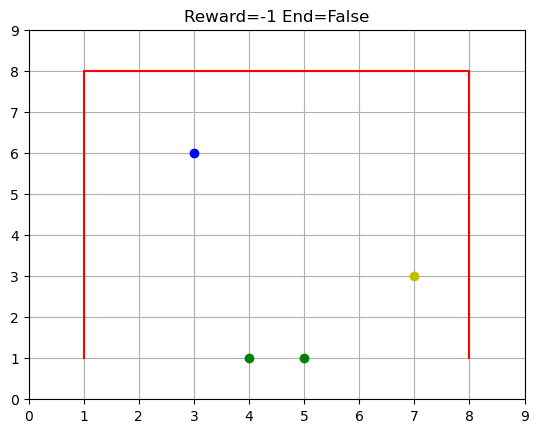

INFO:tensorflow:Restoring parameters from savemodel/model.ckpt


KeyboardInterrupt: 

In [46]:

def soccerpredictwiths(s):
    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph('savemodel/model.ckpt.meta')
        new_saver.restore(sess, tf.train.latest_checkpoint('savemodel/'))
        graph = tf.get_default_graph()
        W = graph.get_tensor_by_name("W:0")
        Qout = tf.matmul(inputs1,W)
        predict = tf.argmax(Qout,1)
        a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(observations)[s:s+1]})
        return a[0]


s = env.reset()
d=False


while True:
    s = env.reset()
    d=False    
    
    while True:
        a = soccerpredictwiths(s)
        
        s,r,d = env.step(a)        
        
        clear_output()
        env.render()    
        if d == True:
            break
    
    
    


In [21]:
import os
folder = 'savemodel/'

os.listdir(folder) 

['model.ckpt.data-00000-of-00001', 'model.ckpt.index', 'model.ckpt.meta']

[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [0, 12], [0, 13], [0, 14], [0, 15], [0, 16], [0, 17], [0, 18], [0, 19], [0, 20], [0, 21], [0, 22], [0, 23], [0, 24], [0, 25], [100, 26], [0, 27], [100, 28], [100, 29], [0, 30], [0, 31], [0, 32], [0, 33], [100, 34], [0, 35], [0, 36], [0, 37], [0, 38], [100, 39], [0, 40], [0, 41], [0, 42], [0, 43], [0, 44], [0, 45], [0, 46], [0, 47], [100, 48], [0, 49], [0, 50], [0, 51], [0, 52], [0, 53], [0, 54], [0, 55], [0, 56], [0, 57], [0, 58], [0, 59], [0, 60], [0, 61], [0, 62], [0, 63], [100, 64], [0, 65], [0, 66], [0, 67], [0, 68], [0, 69], [0, 70], [100, 71], [0, 72], [0, 73], [0, 74], [0, 75], [0, 76], [0, 77], [100, 78], [0, 79], [100, 80], [0, 81], [100, 82], [0, 83], [0, 84], [0, 85], [0, 86], [0, 87], [100, 88], [100, 89], [0, 90], [0, 91], [0, 92], [0, 93], [0, 94], [0, 95], [100, 96], [0, 97], [0, 98], [0, 99], [0, 100], [0, 101], [0, 102], [0, 103], [0, 104], [0, 105], [0, 106], [0, 107], [

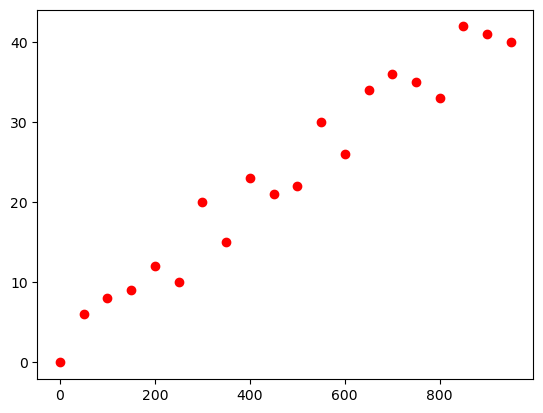

In [55]:
import matplotlib.pyplot as plt
print(rGoalList)

c = 0
for point in rGoalList:
    #id poit[0] is 100 then count it and plot it every 10 point[1]
    if point[0] == 100:
        c=c+1
    if point[1] % 50 == 0:
        plt.plot(point[1], c, 'ro')
        c=0  
    
    